In [2]:
import warnings
warnings.filterwarnings("ignore")
from anndata import AnnData
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import copy
import scipy.sparse as sp

import os
import cv2
import skimage as ski
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

from st_processing import dis_two_point,get_chip_coord,get_distance_from_point_to_line,get_piexl_coods,get_piexl_coods_Mchip,getLinearEquation_new
from st_processing import rgb2gray,adata_flip,adata_Srotate,get_HE_mask_3d,get_HE_mask
from st_processing import get_adata_STARsolo,get_adata_STARsolo_10x
from st_processing import load_image,Srotate

import loompy

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'

In [2]:
df_marker=pd.read_csv('../file/Mouse_Embryo_Brain_3D/3D marker.txt',sep='\t',index_col='sample_id')
df_marker

,HE1,marker1,HE2,marker2,Spot1,Spot2,Spot3
sample_id,,,,,,,
sample10-2,"520,293","304,384","4843,4586","4613,4646","618,725","653,4246","4143,684"
sample10-3,"476,436","247,501","4823,4433","4574,4504","632,843","666,4370","4158,808"
sample10-4,"520,440","305,528","4831,4621","4610,4684","644,765","684,4284","4165,730"
sample10-5,"524,238","302,351","4921,4559","4683,4659","737,761","775,4280","4258,725"
sample10-6,"712,396","481,470","4873,4450","4629,4520","803,793","839,4310","4327,757"
...,...,...,...,...,...,...,...
sample9-1,"174,552","320,395","4317,4668","4372,4521","735,569","704,4093","4257,588"
sample9-2,"316,315","394,170","4504,4337","4503,4213","710,538","679,4063","4234,558"
sample9-3,"278,495","311,342","4558,4826","4493,4695","644,661","613,4186","4168,680"


In [2]:
df_Regist=pd.read_csv('../file/Mouse_Embryo_Brain_3D/img-3D-Registration-Auto-new.csv')
df_Regist

,ID,seq_id,type,angle-shun,center_col,center_row,col_x_1,row_y_1,angle_shun1,angle_shun2,col_x_2,row_y_2
0,T9-5-1-HE,1,ST,75,693.0,446.0,-360.0,-113.0,75,0.0,0.0,0.0
1,Slide1-6,2,Slide,75,199.0,234.5,134.0,98.5,75,1.0,-4.0,0.0
2,Slide1-7,4,Slide,-110,164.0,185.0,169.0,148.0,-110,1.0,-10.0,10.0
3,T9-5-2-HE,6,ST,-110,338.5,586.0,-5.5,-253.0,-110,-1.0,-2.0,0.0
4,Slide1-8,7,Slide,-110,175.5,179.5,157.5,153.5,-110,-1.0,2.0,-6.0
...,...,...,...,...,...,...,...,...,...,...,...,...
313,T9-20-8-HE,623,ST,-140,420.0,462.0,-87.0,-129.0,-140,1.0,-6.0,8.0
314,Slide22-8,625,Slide,-120,273.4,256.0,59.6,77.0,-120,-1.0,2.0,0.0
315,Slide22-9,627,Slide,-100,249.2,252.1,83.8,80.9,-100,1.0,4.0,10.0
316,T9-20-9-HE,629,ST,-95,388.9,570.7,-55.9,-237.7,-95,-1.0,-4.0,-10.0


In [4]:
if 'adata_3d' in globals():
    del adata_3d

#----------时间 进度条----------#
import time
localtime = time.asctime( time.localtime(time.time()) )
print ("本地时间为 :", localtime)
print("执行开始".center(100,"-"))
start = time.perf_counter()
scale=len(df_Regist.index[0:160])##循环次数
tim=0
#----------时间 进度条----------#

for i in df_Regist.index[0:160]:
    
    tim=tim+1
    col_x1=df_Regist.loc[i,'col_x_1']
    col_x2=df_Regist.loc[i,'col_x_2']
    angle=df_Regist.loc[i,'angle_shun1']+df_Regist.loc[i,'angle_shun2']
    row_y1=df_Regist.loc[i,'row_y_1']
    row_y2=df_Regist.loc[i,'row_y_2']

    center_col=df_Regist.loc[i,'center_col']
    center_row=df_Regist.loc[i,'center_row']

    name_id_raw=df_Regist.loc[i,'ID']
    seq_id=df_Regist.loc[i,'seq_id']

    name_id=name_id_raw.replace('T9-','')
    sample=name_id.replace('-HE','')
    
    path='../file/Mouse_Embryo_Brain_3D/st_adata/adata_'+sample+'.h5ad'
    
    if os.path.exists(path):
        print(path)
        print(f'Seq_id: {seq_id} ; sample: {sample}')

        #读取adata
        adata = sc.read(path)
        adata.obs=adata.obs.iloc[:,0:4]#adata.obs.iloc[:,0:6]
        adata.var=adata.var.iloc[:,0:2]
        adata.obs_names=[n+'-z'+str(seq_id) for n in adata.obs_names]
        adata.obs['z']=df_Regist.loc[i,'seq_id']
        adata.obs['sample']=sample
        del adata.layers['ambiguous']
        del adata.uns
        
        HE_file='../Mouse_Embryo_Brain_3D_T9_70_50um/data/Image/T9-'+sample+'-HE.png'
        img_HE = np.array(Image.open(HE_file)) 

        img_file_path='../file/Mouse_Embryo_Brain_3D/3D-HE-ST/'+name_id_raw+'.png'
        dx=15
        img = np.array(Image.open(img_file_path))
        x, y = img.shape[0:2]
        img = cv2.resize(img, (int(y / dx), int(x / dx)))

        d_r=int(10000/dx)
        d_c=int(10000/dx)
        centre_point=(int(d_r/2),int(d_c/2))
        #缩放比例
        dx=(img.shape[0]/img_HE.shape[0])
        #0.缩放
        spatial_coordadata=adata.obsm['spatial'].copy()
        if sample in ['8-9','8-4','8-3','7-5']:
            print(sample)
            spatial_coordadata[:,1]= img_HE.shape[0] - spatial_coordadata[:,1]
        del img_HE
        del img
        spatial_coord=spatial_coordadata*dx#（col,row）
        spatial_coord=spatial_coord[:,::-1]#（row,col）
        #1.平移到中心
        spatial_coord[:,0]=spatial_coord[:,0]+row_y1
        spatial_coord[:,1]=spatial_coord[:,1]+col_x1
        #2.按指定点旋转坐标点-顺时针旋转 
        for r in range(spatial_coord.shape[0]):
            point=spatial_coord[r,:]
            point_new=Srotate(angle, point, centre_point)
            spatial_coord[r,:]=point_new
        #3.平移
        spatial_coord[:,0]=spatial_coord[:,0]+row_y2
        spatial_coord[:,1]=spatial_coord[:,1]+col_x2
        spatial_coord=spatial_coord.astype(int)

        #生成新坐标
        adata.obsm['spatial_3d_align']=np.hstack((spatial_coord,np.array(adata.obs['z']).reshape([spatial_coord.shape[0], 1]))) # 'raw' 'col' 'z'
        
        
        if 'adata_3d' in globals():
            adata_3d = sc.concat([adata_3d,adata],join='outer')

        else:
            adata_3d=adata

        print(adata_3d.n_vars)

        #----------时间 进度条----------#
        print("\r{:^3.0f}%[{}->{}]{:.2f}s".format((tim / scale) * 100,
                                              "*" *  int((tim / scale) * 100),
                                              "." * (100-int((tim / scale) * 100)),
                                              time.perf_counter() - start),end = "")
        print(' ')
        tt=time.perf_counter() - start
        #----------时间 进度条----------#
            
#----------时间 进度条----------#        
print("\n"+"执行结束".center(100 ,"-")+"\n"+"共计用时:")
print("{:.0f}h:{:.0f}m:{:.0f}s".format(int(tt/3600),
     int((tt%3600)/60),
     int(tt%60)))
localtime = time.asctime( time.localtime(time.time()) )
print ("本地时间为 :", localtime)
#----------时间 进度条----------#            

本地时间为 : Wed Mar 27 23:52:16 2024
------------------------------------------------执行开始------------------------------------------------
../file/Mouse_Embryo_Brain_3D/st_adata/adata_5-4.h5ad
Seq_id: 16 ; sample: 5-4
13034
 6 %[******->..............................................................................................]5.84s 
../file/Mouse_Embryo_Brain_3D/st_adata/adata_5-5.h5ad
Seq_id: 21 ; sample: 5-5
14127
 8 %[********->............................................................................................]11.86s 
../file/Mouse_Embryo_Brain_3D/st_adata/adata_5-7.h5ad
Seq_id: 31 ; sample: 5-7
14920
12 %[***********->.........................................................................................]17.66s 
../file/Mouse_Embryo_Brain_3D/st_adata/adata_5-8.h5ad
Seq_id: 36 ; sample: 5-8
15256
14 %[*************->.......................................................................................]23.54s 
../file/Mouse_Embryo_Brain_3D/st_adata/adata_5-9.h5ad
Seq_id: 4

In [5]:
adata_3d.write('../file/Mouse_Embryo_Brain_3D/st_adata/adata_3d_1_160.h5ad')

In [6]:
if 'adata_3d' in globals():
    del adata_3d
#----------时间 进度条----------#
import time
localtime = time.asctime( time.localtime(time.time()) )
print ("本地时间为 :", localtime)
print("执行开始".center(100,"-"))
start = time.perf_counter()
scale=len(df_Regist.index[160:])##循环次数
tim=0
#----------时间 进度条----------#

for i in df_Regist.index[160:]:
    
    tim=tim+1
    col_x1=df_Regist.loc[i,'col_x_1']
    col_x2=df_Regist.loc[i,'col_x_2']
    angle=df_Regist.loc[i,'angle_shun1']+df_Regist.loc[i,'angle_shun2']
    row_y1=df_Regist.loc[i,'row_y_1']
    row_y2=df_Regist.loc[i,'row_y_2']

    center_col=df_Regist.loc[i,'center_col']
    center_row=df_Regist.loc[i,'center_row']

    name_id_raw=df_Regist.loc[i,'ID']
    seq_id=df_Regist.loc[i,'seq_id']

    name_id=name_id_raw.replace('T9-','')
    sample=name_id.replace('-HE','')
    
    path='../file/Mouse_Embryo_Brain_3D/st_adata/adata_'+sample+'.h5ad'
    
    if os.path.exists(path):
        print(path)
        print(f'Seq_id: {seq_id} ; sample: {sample}')

        #读取adata
        adata = sc.read(path)
        adata.obs=adata.obs.iloc[:,0:4]#adata.obs.iloc[:,0:6]
        adata.var=adata.var.iloc[:,0:2]
        adata.obs_names=[n+'-z'+str(seq_id) for n in adata.obs_names]
        adata.obs['z']=df_Regist.loc[i,'seq_id']
        adata.obs['sample']=sample
        del adata.layers['ambiguous']
        del adata.uns
        
        HE_file='../Mouse_Embryo_Brain_3D_T9_70_50um/data/Image/T9-'+sample+'-HE.png'
        img_HE = np.array(Image.open(HE_file)) 

        img_file_path='../file/Mouse_Embryo_Brain_3D/3D-HE-ST/'+name_id_raw+'.png'
        dx=15
        img = np.array(Image.open(img_file_path))
        x, y = img.shape[0:2]
        img = cv2.resize(img, (int(y / dx), int(x / dx)))

        d_r=int(10000/dx)
        d_c=int(10000/dx)
        centre_point=(int(d_r/2),int(d_c/2))
        #缩放比例
        dx=(img.shape[0]/img_HE.shape[0])
        #0.缩放
        spatial_coordadata=adata.obsm['spatial'].copy()
        if sample in ['8-9','8-4','8-3','7-5']:
            print(sample)
            spatial_coordadata[:,1]= img_HE.shape[0] - spatial_coordadata[:,1]
        del img_HE
        del img
        spatial_coord=spatial_coordadata*dx#（col,row）
        spatial_coord=spatial_coord[:,::-1]#（row,col）
        #1.平移到中心
        spatial_coord[:,0]=spatial_coord[:,0]+row_y1
        spatial_coord[:,1]=spatial_coord[:,1]+col_x1
        #2.按指定点旋转坐标点-顺时针旋转 
        for r in range(spatial_coord.shape[0]):
            point=spatial_coord[r,:]
            point_new=Srotate(angle, point, centre_point)
            spatial_coord[r,:]=point_new
        #3.平移
        spatial_coord[:,0]=spatial_coord[:,0]+row_y2
        spatial_coord[:,1]=spatial_coord[:,1]+col_x2
        spatial_coord=spatial_coord.astype(int)

        #生成新坐标
        adata.obsm['spatial_3d_align']=np.hstack((spatial_coord,np.array(adata.obs['z']).reshape([spatial_coord.shape[0], 1]))) # 'raw' 'col' 'z'
        
        
        if 'adata_3d' in globals():
            adata_3d = sc.concat([adata_3d,adata],join='outer')

        else:
            adata_3d=adata

        print(adata_3d.n_vars)

        #----------时间 进度条----------#
        print("\r{:^3.0f}%[{}->{}]{:.2f}s".format((tim / scale) * 100,
                                              "*" *  int((tim / scale) * 100),
                                              "." * (100-int((tim / scale) * 100)),
                                              time.perf_counter() - start),end = "")
        print(' ')
        tt=time.perf_counter() - start
        #----------时间 进度条----------#
            
#----------时间 进度条----------#        
print("\n"+"执行结束".center(100 ,"-")+"\n"+"共计用时:")
print("{:.0f}h:{:.0f}m:{:.0f}s".format(int(tt/3600),
     int((tt%3600)/60),
     int(tt%60)))
localtime = time.asctime( time.localtime(time.time()) )
print ("本地时间为 :", localtime)
#----------时间 进度条----------#    

本地时间为 : Wed Mar 27 23:58:31 2024
------------------------------------------------执行开始------------------------------------------------
../file/Mouse_Embryo_Brain_3D/st_adata/adata_13-4.h5ad
Seq_id: 306 ; sample: 13-4
19479
 1 %[->....................................................................................................]6.72s 
../file/Mouse_Embryo_Brain_3D/st_adata/adata_13-6.h5ad
Seq_id: 317 ; sample: 13-6
20041
 3 %[**->..................................................................................................]14.36s 
../file/Mouse_Embryo_Brain_3D/st_adata/adata_13-7.h5ad
Seq_id: 321 ; sample: 13-7
20115
 4 %[***->.................................................................................................]22.31s 
../file/Mouse_Embryo_Brain_3D/st_adata/adata_13-8.h5ad
Seq_id: 327 ; sample: 13-8
20129
 6 %[*****->...............................................................................................]30.39s 
../file/Mouse_Embryo_Brain_3D/st_adata/adata_14-1.h

In [7]:
adata_3d.write('../file/Mouse_Embryo_Brain_3D/st_adata/adata_3d_160_end.h5ad')

In [8]:
adata_3d=sc.read('../file/Mouse_Embryo_Brain_3D/st_adata/adata_3d_1_160.h5ad')

In [9]:
adata_3d2=sc.read('../file/Mouse_Embryo_Brain_3D/st_adata/adata_3d_160_end.h5ad')

In [10]:
adata_3d=sc.concat([adata_3d,adata_3d2],join='outer')
del adata_3d2

In [11]:
adata_3d.write('../file/Mouse_Embryo_Brain_3D/st_adata/adata_3D_raw.h5ad')

## 1.单细胞数据

In [ ]:
adata_e18=sc.read('../file/Mouse_Embryo_Brain_3D/ref_developing_mouse_brain/adata_e18.h5ad')
adata_e18

In [ ]:
selected = filter_genes(adata_e18, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
adata_e18 = adata_e18[:, selected]

In [ ]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_e18,
                        batch_key='DonorID',
                        labels_key='cell_type',
                        categorical_covariate_keys=['Tissue'],
                        continuous_covariate_keys=None
                       )

In [ ]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_e18)
# view anndata_setup as a sanity check
mod.view_anndata_setup()

In [8]:
mod.train(max_epochs=250, use_gpu=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 250/250: 100%|██████████| 250/250 [13:23<00:00,  3.19s/it, v_num=1, elbo_train=1.91e+8]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [13:23<00:00,  3.21s/it, v_num=1, elbo_train=1.91e+8]


In [9]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_e18 = mod.export_posterior(
    adata_e18, 
    sample_kwargs = {'num_samples': 1000, 'batch_size': 2500, 'use_gpu': False},
    export_slot = 'mod',
    add_to_varm = ["means","stds","q05","q95"],
    scale_average_detection = True
    
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_e18.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [05:27<00:00,  3.05it/s]


'../file/Mouse_Embryo_Brain_3D/cell2location_result/reference_signatures/sc.h5ad'

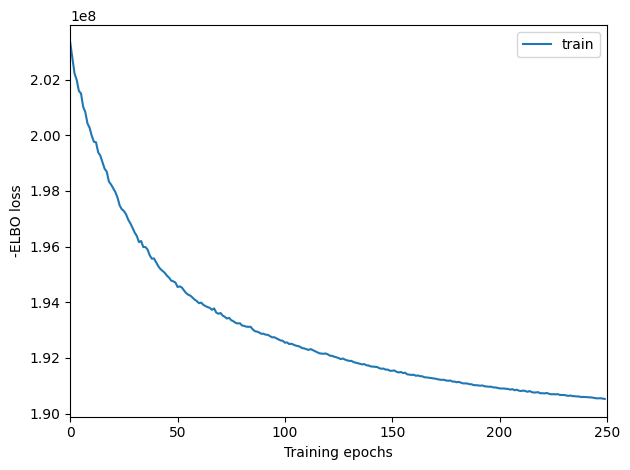

In [25]:
mod.plot_history(0)

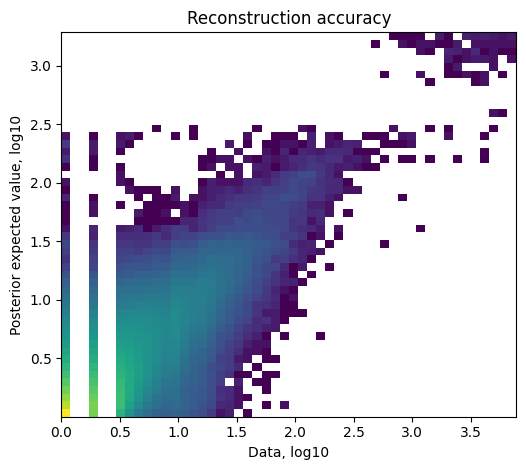

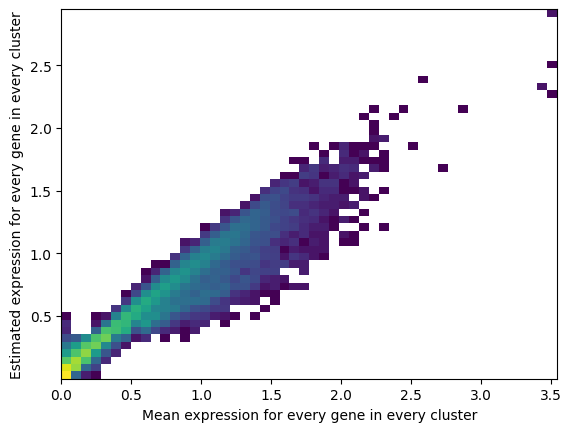

In [10]:
mod.plot_QC()

In [11]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_e18.varm.keys():
    inf_aver = adata_e18.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_e18.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_e18.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_e18.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_e18.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,Blood-Erythrocyte,Blood-Erythroid progenitor,Blood-Platelet,Choroid plexus-Choroid plexus,Ectoderm-Olfactory epithelium
Accession,,,,,
ENSMUSG00000026478,0.001964,0.016413,0.145247,0.710017,0.237591
ENSMUSG00000057092,0.000965,0.047130,0.203793,0.023970,0.201788
ENSMUSG00000032796,0.003793,0.019923,0.146994,0.012001,1.224278
ENSMUSG00000051022,0.000872,0.046854,0.136870,0.075047,0.263424
ENSMUSG00000028773,0.005735,0.064756,0.160033,4.813649,0.151590


In [12]:
inf_aver.to_csv(f'{ref_run_name}/inf_aver.csv')

In [10]:
inf_aver=pd.read_csv(f'{ref_run_name}/inf_aver.csv',index_col=0)
inf_aver

,Blood-Erythrocyte,Blood-Erythroid progenitor,Blood-Platelet,Choroid plexus-Choroid plexus,Ectoderm-Olfactory epithelium,Ependymal-Forebrain,Ependymal-Mixed region,Fibroblast-Arachnoid,Fibroblast-Arachnoid barrier cells,Fibroblast-Dura,...,Radial glia-Hypothalamus,Radial glia-Late isthmic organizer,Radial glia-Midbrain,Radial glia-Spinal cord,Schwann cell-Schwann cell,Subcommissural organ-Subcommissural organ hypendymal cell,Vascular-Angioblast,Vascular-Endothelial,Vascular-Pericyte,Vascular-Vascular smooth muscle
Accession,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000026478,0.001964,0.016413,0.145247,0.710017,0.237591,0.315688,0.425366,1.201466,0.590600,0.823968,...,0.208079,0.140959,0.305864,0.128365,2.795786,0.583979,0.874279,2.796536,1.444503,2.492723
ENSMUSG00000057092,0.000965,0.047130,0.203793,0.023970,0.201788,0.035090,0.042502,0.013023,0.209718,0.015770,...,0.114252,0.271736,0.143229,0.168276,0.457009,0.097186,0.348218,0.001470,0.009513,0.081556
ENSMUSG00000032796,0.003793,0.019923,0.146994,0.012001,1.224278,0.028637,0.116822,0.253008,0.150535,0.021515,...,0.100496,0.188107,0.107143,0.212035,0.057709,0.039695,0.131978,0.777968,0.144397,0.187955
ENSMUSG00000051022,0.000872,0.046854,0.136870,0.075047,0.263424,0.174661,0.379845,0.182568,0.143605,2.412482,...,0.115628,0.181714,1.051621,0.157035,0.406272,0.528642,0.211927,0.332654,0.005222,0.024296
ENSMUSG00000028773,0.005735,0.064756,0.160033,4.813649,0.151590,0.010794,0.014978,0.116195,0.663236,0.122867,...,0.080787,0.185577,0.089147,0.049884,0.017571,0.122014,0.205518,0.010788,0.020608,1.756522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000023236,0.016568,0.054449,0.084535,0.140319,2.209835,0.584843,0.998544,0.172735,0.132168,0.072060,...,0.938240,0.170666,1.517955,1.894157,0.126339,0.263457,0.174006,0.057249,0.054102,0.351873
ENSMUSG00000031600,0.001958,0.043198,0.159580,0.437646,0.215178,0.400147,0.767140,0.209542,0.591916,0.237197,...,0.353786,1.248698,0.332948,0.399059,0.127229,0.407518,0.186650,0.482056,0.173562,0.291564
ENSMUSG00000041328,0.003239,0.039438,0.110200,0.321319,1.485504,0.390408,0.603443,0.312309,0.569641,0.268391,...,0.210529,0.150288,0.309247,0.264640,0.295841,0.336414,0.913242,0.432700,0.166043,0.409243


## 2. ST adata

In [4]:
adata_3d=sc.read('../file/Mouse_Embryo_Brain_3D/st_adata/adata_3D_raw.h5ad')
geneInfo=pd.read_csv('/histor/zhao/pangkun/JupyterLab/Task/Public_data/reference/mm10/geneInfo.txt',sep='\t',index_col=0)
geneInfo=geneInfo.loc[adata_3d.var_names,:]
adata_3d.var=geneInfo

In [5]:
# find mitochondria-encoded (MT) genes
adata_3d.var["mt"] = adata_3d.var.Symbol.str.startswith("mt-")
#adata_3d.obsm['mt'] = adata_3d[:, adata_3d.var['mt'].values].X.toarray()
adata_3d = adata_3d[:, ~adata_3d.var['mt'].values]

In [6]:
adata_3d

View of AnnData object with n_obs × n_vars = 97830 × 21856
    obs: 'sample', 'reg', 'Spot_col', 'Spot_row', 'z'
    var: 'Symbol', 'type', 'mt'
    obsm: 'spatial', 'spatial_3d_align'
    layers: 'spliced', 'unspliced'

In [7]:
# import random
# original_numbers = list(range(adata_3d.n_obs))
# shuffled_numbers = random.sample(original_numbers, len(original_numbers))

# #保存变量
import pickle
# pickle.dump(shuffled_numbers,open('../file/Mouse_Embryo_Brain_3D/shuffled_numbers.pkl','wb'))  
shuffled_numbers=pickle.load(open('../file/Mouse_Embryo_Brain_3D/shuffled_numbers.pkl','rb'))

In [8]:
len(shuffled_numbers)

97830

## 3.1

In [29]:
adata_st=adata_3d[shuffled_numbers[0:13975]]#[adata_3d.obs['z']<190]
sc.pp.filter_genes(adata_st, min_cells=10)
adata_st

AnnData object with n_obs × n_vars = 13975 × 19732
    obs: 'sample', 'reg', 'Spot_col', 'Spot_row', 'z'
    var: 'Symbol', 'type', 'mt', 'n_cells'
    obsm: 'spatial', 'spatial_3d_align'
    layers: 'spliced', 'unspliced'

In [30]:
inf_aver=pd.read_csv(f'{ref_run_name}/inf_aver.csv',index_col=0)
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_st.var_names, inf_aver.index)
adata_st = adata_st[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_st, batch_key="sample")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [31]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_st, cell_state_df=inf_aver,
    N_cells_per_location=20,
    detection_alpha=20, #count与HE细胞密集程度高：200 esle 20
    detection_mean_per_sample=True #多个空间样本 True
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.3.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  93   │
│         n_cells          │ 13975 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 14185 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │    5-4     │          0          │
│                     │    5-5     │          1          │
│                     │    5-7     │          2          │
│                     │    5-8     │          3          │
│                     │    5-9     │          4          │
│                     │    7-1     │          5          │
│                     │    7-2     │          6          │
│                     │    7-3     │          7          │
│                     │    7-4     │          8          │
│                     │    7-5     │          9          │
│                     │    7-8     │         10          │
│                     │    8-3     │         11          │
│                     │    8-4     │         12          │
│                     │    8-5     │         13          │
│                     │    8-6     │         14          │
│                     │    8-7     │         15          │
│                     │    8-8     │         16          │
│                     │    8-9     │         17          │
│                     │    9-1     │         18          │
│                     │    9-2     │         19          │
│                     │    9-3     │         20          │
│                     │    9-8     │         21          │
│                     │    9-9     │         22          │
│                     │    10-2    │         23          │
│                     │    10-3    │         24          │
│                     │    10-4    │         25          │
│                     │    10-5    │         26          │
│                     │    10-6    │         27          │
│                     │    10-7    │         28          │
│                     │    10-8    │         29          │
│                     │    10-9    │         30          │
│                     │    11-3    │         31          │
│                     │    11-5    │         32          │
│                     │    11-6    │         33          │
│                     │    11-7    │         34          │
│                     │    11-9    │         35          │
│                     │    13-1    │         36          │
│                     │    13-2    │         37          │
│                     │    13-3    │         38          │
│                     │    13-4    │         39          │
│                     │    13-6    │         40          │
│                     │    13-7    │         41          │
│                     │    13-8    │         42          │
│                     │    14-1    │         43          │
│                     │    14-3    │         44          │
│                     │    14-4    │         45          │
│                     │    14-5    │         46          │
│                     │    14-6    │         47          │
│                     │    14-7    │         48          │
│                     │    14-8    │         49          │
│                     │    14-9    │         50          │
│                     │    16-1    │         51          │
│                     │    16-2    │         52          │
│                     │    16-3    │         53          │
│                     │    16-4    │         54          │
│                     │    16-5    │         55          │
│                     │    16-6    │         56          │
│                     │    16-7    │         57          │
│                     │    16-8    │         58          │
│                     │    16-9    │         59          │
│                     │    17-2    │         60          │
│                     │    17-3    │         61          │
│                     │    17-4    │         62          │
│                     │    17-5    │         63

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [32]:
mod.train(max_epochs=30000,
          batch_size=None,
          use_gpu=True
         )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 30000/30000: 100%|██████████| 30000/30000 [2:04:54<00:00,  3.61it/s, v_num=1, elbo_train=1.71e+8]  

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|██████████| 30000/30000 [2:04:54<00:00,  4.00it/s, v_num=1, elbo_train=1.71e+8]


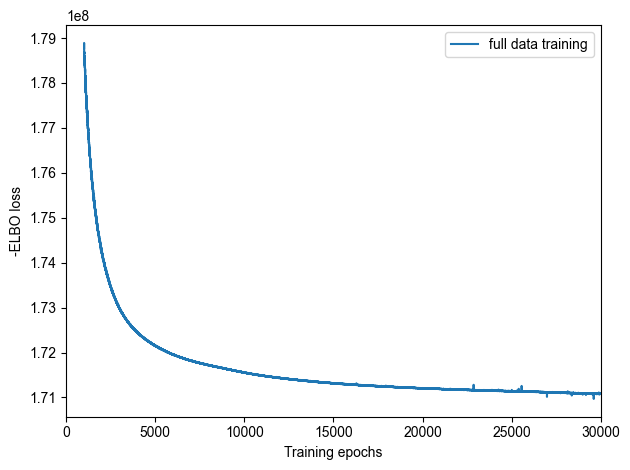

In [33]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training'])

In [34]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_st = mod.export_posterior(
    adata_st, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name1}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name1}/sp.h5ad"
adata_st.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:46<00:00, 21.60it/s]


'../file/Mouse_Embryo_Brain_3D/cell2location_result/cell2location_map_st1/sp.h5ad'

## 3.2

In [35]:



adata_st=adata_3d[shuffled_numbers[13975:27950]]#adata_3d[(adata_3d.obs['z']>189)&(adata_3d.obs['z']<270)]
sc.pp.filter_genes(adata_st, min_cells=10)
adata_st

AnnData object with n_obs × n_vars = 13975 × 19720
    obs: 'sample', 'reg', 'Spot_col', 'Spot_row', 'z'
    var: 'Symbol', 'type', 'mt', 'n_cells'
    obsm: 'spatial', 'spatial_3d_align'
    layers: 'spliced', 'unspliced'

In [36]:
inf_aver=pd.read_csv(f'{ref_run_name}/inf_aver.csv',index_col=0)
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_st.var_names, inf_aver.index)
adata_st = adata_st[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_st, batch_key="sample")

In [37]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_st, cell_state_df=inf_aver,
    N_cells_per_location=20,
    detection_alpha=20, #count与HE细胞密集程度高：200 esle 20
    detection_mean_per_sample=True #多个空间样本 True
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.3.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  93   │
│         n_cells          │ 13975 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 14170 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │    5-4     │          0          │
│                     │    5-5     │          1          │
│                     │    5-7     │          2          │
│                     │    5-8     │          3          │
│                     │    5-9     │          4          │
│                     │    7-1     │          5          │
│                     │    7-2     │          6          │
│                     │    7-3     │          7          │
│                     │    7-4     │          8          │
│                     │    7-5     │          9          │
│                     │    7-8     │         10          │
│                     │    8-3     │         11          │
│                     │    8-4     │         12          │
│                     │    8-5     │         13          │
│                     │    8-6     │         14          │
│                     │    8-7     │         15          │
│                     │    8-8     │         16          │
│                     │    8-9     │         17          │
│                     │    9-1     │         18          │
│                     │    9-2     │         19          │
│                     │    9-3     │         20          │
│                     │    9-8     │         21          │
│                     │    9-9     │         22          │
│                     │    10-2    │         23          │
│                     │    10-3    │         24          │
│                     │    10-4    │         25          │
│                     │    10-5    │         26          │
│                     │    10-6    │         27          │
│                     │    10-7    │         28          │
│                     │    10-8    │         29          │
│                     │    10-9    │         30          │
│                     │    11-3    │         31          │
│                     │    11-5    │         32          │
│                     │    11-6    │         33          │
│                     │    11-7    │         34          │
│                     │    11-9    │         35          │
│                     │    13-1    │         36          │
│                     │    13-2    │         37          │
│                     │    13-3    │         38          │
│                     │    13-4    │         39          │
│                     │    13-6    │         40          │
│                     │    13-7    │         41          │
│                     │    13-8    │         42          │
│                     │    14-1    │         43          │
│                     │    14-3    │         44          │
│                     │    14-4    │         45          │
│                     │    14-5    │         46          │
│                     │    14-6    │         47          │
│                     │    14-7    │         48          │
│                     │    14-8    │         49          │
│                     │    14-9    │         50          │
│                     │    16-1    │         51          │
│                     │    16-2    │         52          │
│                     │    16-3    │         53          │
│                     │    16-4    │         54          │
│                     │    16-5    │         55          │
│                     │    16-6    │         56          │
│                     │    16-7    │         57          │
│                     │    16-8    │         58          │
│                     │    16-9    │         59          │
│                     │    17-2    │         60          │
│                     │    17-3    │         61          │
│                     │    17-4    │         62          │
│                     │    17-5    │         63

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [38]:
mod.train(max_epochs=30000,
          batch_size=None,
          use_gpu=True
         )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 30000/30000: 100%|██████████| 30000/30000 [2:05:23<00:00,  4.01it/s, v_num=1, elbo_train=1.71e+8]  

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|██████████| 30000/30000 [2:05:23<00:00,  3.99it/s, v_num=1, elbo_train=1.71e+8]


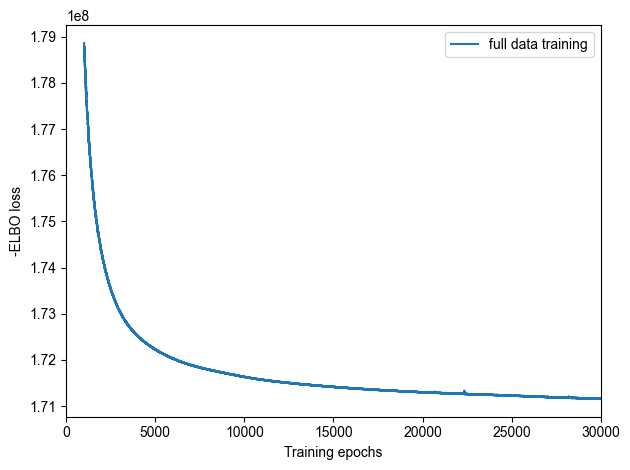

In [39]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [40]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_st = mod.export_posterior(
    adata_st, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name2}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name2}/sp.h5ad"
adata_st.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:44<00:00, 22.37it/s]


'../file/Mouse_Embryo_Brain_3D/cell2location_result/cell2location_map_st2/sp.h5ad'

## 3.3

In [41]:
adata_st=adata_3d[shuffled_numbers[27950:41925]]#adata_3d[(adata_3d.obs['z']>269)&(adata_3d.obs['z']<315)]
sc.pp.filter_genes(adata_st, min_cells=10)
adata_st

AnnData object with n_obs × n_vars = 13975 × 19729
    obs: 'sample', 'reg', 'Spot_col', 'Spot_row', 'z'
    var: 'Symbol', 'type', 'mt', 'n_cells'
    obsm: 'spatial', 'spatial_3d_align'
    layers: 'spliced', 'unspliced'

In [42]:
inf_aver=pd.read_csv(f'{ref_run_name}/inf_aver.csv',index_col=0)
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_st.var_names, inf_aver.index)
adata_st = adata_st[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_st, batch_key="sample")

In [43]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_st, cell_state_df=inf_aver,
    N_cells_per_location=20,
    detection_alpha=20, #count与HE细胞密集程度高：200 esle 20
    detection_mean_per_sample=True #多个空间样本 True
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.3.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  93   │
│         n_cells          │ 13975 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 14181 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │    5-4     │          0          │
│                     │    5-5     │          1          │
│                     │    5-7     │          2          │
│                     │    5-8     │          3          │
│                     │    5-9     │          4          │
│                     │    7-1     │          5          │
│                     │    7-2     │          6          │
│                     │    7-3     │          7          │
│                     │    7-4     │          8          │
│                     │    7-5     │          9          │
│                     │    7-8     │         10          │
│                     │    8-3     │         11          │
│                     │    8-4     │         12          │
│                     │    8-5     │         13          │
│                     │    8-6     │         14          │
│                     │    8-7     │         15          │
│                     │    8-8     │         16          │
│                     │    8-9     │         17          │
│                     │    9-1     │         18          │
│                     │    9-2     │         19          │
│                     │    9-3     │         20          │
│                     │    9-8     │         21          │
│                     │    9-9     │         22          │
│                     │    10-2    │         23          │
│                     │    10-3    │         24          │
│                     │    10-4    │         25          │
│                     │    10-5    │         26          │
│                     │    10-6    │         27          │
│                     │    10-7    │         28          │
│                     │    10-8    │         29          │
│                     │    10-9    │         30          │
│                     │    11-3    │         31          │
│                     │    11-5    │         32          │
│                     │    11-6    │         33          │
│                     │    11-7    │         34          │
│                     │    11-9    │         35          │
│                     │    13-1    │         36          │
│                     │    13-2    │         37          │
│                     │    13-3    │         38          │
│                     │    13-4    │         39          │
│                     │    13-6    │         40          │
│                     │    13-7    │         41          │
│                     │    13-8    │         42          │
│                     │    14-1    │         43          │
│                     │    14-3    │         44          │
│                     │    14-4    │         45          │
│                     │    14-5    │         46          │
│                     │    14-6    │         47          │
│                     │    14-7    │         48          │
│                     │    14-8    │         49          │
│                     │    14-9    │         50          │
│                     │    16-1    │         51          │
│                     │    16-2    │         52          │
│                     │    16-3    │         53          │
│                     │    16-4    │         54          │
│                     │    16-5    │         55          │
│                     │    16-6    │         56          │
│                     │    16-7    │         57          │
│                     │    16-8    │         58          │
│                     │    16-9    │         59          │
│                     │    17-2    │         60          │
│                     │    17-3    │         61          │
│                     │    17-4    │         62          │
│                     │    17-5    │         63

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [44]:
mod.train(max_epochs=30000,
          batch_size=None,
          use_gpu=True
         )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 30000/30000: 100%|██████████| 30000/30000 [2:05:45<00:00,  3.94it/s, v_num=1, elbo_train=1.71e+8]  

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|██████████| 30000/30000 [2:05:45<00:00,  3.98it/s, v_num=1, elbo_train=1.71e+8]


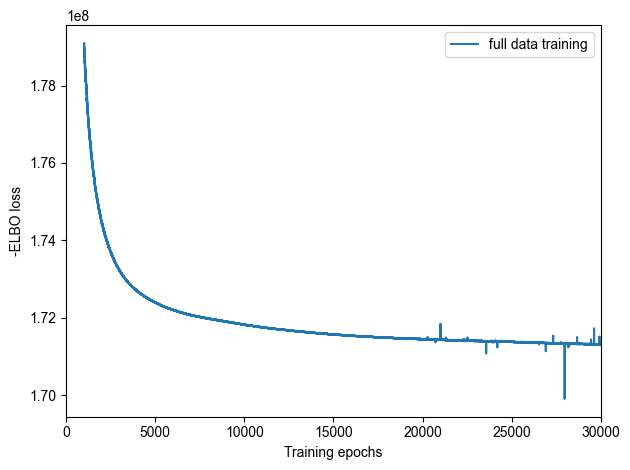

In [45]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [46]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_st = mod.export_posterior(
    adata_st, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name3}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name3}/sp.h5ad"
adata_st.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:47<00:00, 21.14it/s]


'../file/Mouse_Embryo_Brain_3D/cell2location_result/cell2location_map_st3/sp.h5ad'

## 3.4

In [47]:
adata_st=adata_3d[shuffled_numbers[41925:55900]]#adata_3d[(adata_3d.obs['z']>314)&(adata_3d.obs['z']<355)]
sc.pp.filter_genes(adata_st, min_cells=10)
adata_st

AnnData object with n_obs × n_vars = 13975 × 19703
    obs: 'sample', 'reg', 'Spot_col', 'Spot_row', 'z'
    var: 'Symbol', 'type', 'mt', 'n_cells'
    obsm: 'spatial', 'spatial_3d_align'
    layers: 'spliced', 'unspliced'

In [48]:
inf_aver=pd.read_csv(f'{ref_run_name}/inf_aver.csv',index_col=0)
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_st.var_names, inf_aver.index)
adata_st = adata_st[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_st, batch_key="sample")

In [49]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_st, cell_state_df=inf_aver,
    N_cells_per_location=20,
    detection_alpha=20, #count与HE细胞密集程度高：200 esle 20
    detection_mean_per_sample=True #多个空间样本 True
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.3.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  93   │
│         n_cells          │ 13975 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 14163 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │    5-4     │          0          │
│                     │    5-5     │          1          │
│                     │    5-7     │          2          │
│                     │    5-8     │          3          │
│                     │    5-9     │          4          │
│                     │    7-1     │          5          │
│                     │    7-2     │          6          │
│                     │    7-3     │          7          │
│                     │    7-4     │          8          │
│                     │    7-5     │          9          │
│                     │    7-8     │         10          │
│                     │    8-3     │         11          │
│                     │    8-4     │         12          │
│                     │    8-5     │         13          │
│                     │    8-6     │         14          │
│                     │    8-7     │         15          │
│                     │    8-8     │         16          │
│                     │    8-9     │         17          │
│                     │    9-1     │         18          │
│                     │    9-2     │         19          │
│                     │    9-3     │         20          │
│                     │    9-8     │         21          │
│                     │    9-9     │         22          │
│                     │    10-2    │         23          │
│                     │    10-3    │         24          │
│                     │    10-4    │         25          │
│                     │    10-5    │         26          │
│                     │    10-6    │         27          │
│                     │    10-7    │         28          │
│                     │    10-8    │         29          │
│                     │    10-9    │         30          │
│                     │    11-3    │         31          │
│                     │    11-5    │         32          │
│                     │    11-6    │         33          │
│                     │    11-7    │         34          │
│                     │    11-9    │         35          │
│                     │    13-1    │         36          │
│                     │    13-2    │         37          │
│                     │    13-3    │         38          │
│                     │    13-4    │         39          │
│                     │    13-6    │         40          │
│                     │    13-7    │         41          │
│                     │    13-8    │         42          │
│                     │    14-1    │         43          │
│                     │    14-3    │         44          │
│                     │    14-4    │         45          │
│                     │    14-5    │         46          │
│                     │    14-6    │         47          │
│                     │    14-7    │         48          │
│                     │    14-8    │         49          │
│                     │    14-9    │         50          │
│                     │    16-1    │         51          │
│                     │    16-2    │         52          │
│                     │    16-3    │         53          │
│                     │    16-4    │         54          │
│                     │    16-5    │         55          │
│                     │    16-6    │         56          │
│                     │    16-7    │         57          │
│                     │    16-8    │         58          │
│                     │    16-9    │         59          │
│                     │    17-2    │         60          │
│                     │    17-3    │         61          │
│                     │    17-4    │         62          │
│                     │    17-5    │         63

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [50]:
mod.train(max_epochs=30000,
          batch_size=None,
          use_gpu=True
         )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 30000/30000: 100%|██████████| 30000/30000 [2:05:50<00:00,  3.98it/s, v_num=1, elbo_train=1.71e+8]  

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|██████████| 30000/30000 [2:05:50<00:00,  3.97it/s, v_num=1, elbo_train=1.71e+8]


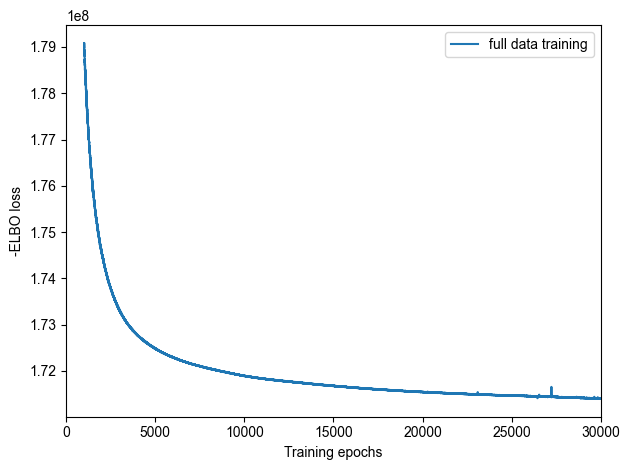

In [51]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [52]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_st = mod.export_posterior(
    adata_st, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name4}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name4}/sp.h5ad"
adata_st.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:54<00:00, 18.23it/s]


'../file/Mouse_Embryo_Brain_3D/cell2location_result/cell2location_map_st4/sp.h5ad'

## 3.5

In [53]:
adata_st=adata_3d[shuffled_numbers[55900:69875]]#adata_3d[(adata_3d.obs['z']>354)&(adata_3d.obs['z']<405)]
sc.pp.filter_genes(adata_st, min_cells=10)
adata_st

AnnData object with n_obs × n_vars = 13975 × 19727
    obs: 'sample', 'reg', 'Spot_col', 'Spot_row', 'z'
    var: 'Symbol', 'type', 'mt', 'n_cells'
    obsm: 'spatial', 'spatial_3d_align'
    layers: 'spliced', 'unspliced'

In [54]:
inf_aver=pd.read_csv(f'{ref_run_name}/inf_aver.csv',index_col=0)
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_st.var_names, inf_aver.index)
adata_st = adata_st[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_st, batch_key="sample")

In [55]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_st, cell_state_df=inf_aver,
    N_cells_per_location=20,
    detection_alpha=20, #count与HE细胞密集程度高：200 esle 20
    detection_mean_per_sample=True #多个空间样本 True
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.3.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  93   │
│         n_cells          │ 13975 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 14176 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │    5-4     │          0          │
│                     │    5-5     │          1          │
│                     │    5-7     │          2          │
│                     │    5-8     │          3          │
│                     │    5-9     │          4          │
│                     │    7-1     │          5          │
│                     │    7-2     │          6          │
│                     │    7-3     │          7          │
│                     │    7-4     │          8          │
│                     │    7-5     │          9          │
│                     │    7-8     │         10          │
│                     │    8-3     │         11          │
│                     │    8-4     │         12          │
│                     │    8-5     │         13          │
│                     │    8-6     │         14          │
│                     │    8-7     │         15          │
│                     │    8-8     │         16          │
│                     │    8-9     │         17          │
│                     │    9-1     │         18          │
│                     │    9-2     │         19          │
│                     │    9-3     │         20          │
│                     │    9-8     │         21          │
│                     │    9-9     │         22          │
│                     │    10-2    │         23          │
│                     │    10-3    │         24          │
│                     │    10-4    │         25          │
│                     │    10-5    │         26          │
│                     │    10-6    │         27          │
│                     │    10-7    │         28          │
│                     │    10-8    │         29          │
│                     │    10-9    │         30          │
│                     │    11-3    │         31          │
│                     │    11-5    │         32          │
│                     │    11-6    │         33          │
│                     │    11-7    │         34          │
│                     │    11-9    │         35          │
│                     │    13-1    │         36          │
│                     │    13-2    │         37          │
│                     │    13-3    │         38          │
│                     │    13-4    │         39          │
│                     │    13-6    │         40          │
│                     │    13-7    │         41          │
│                     │    13-8    │         42          │
│                     │    14-1    │         43          │
│                     │    14-3    │         44          │
│                     │    14-4    │         45          │
│                     │    14-5    │         46          │
│                     │    14-6    │         47          │
│                     │    14-7    │         48          │
│                     │    14-8    │         49          │
│                     │    14-9    │         50          │
│                     │    16-1    │         51          │
│                     │    16-2    │         52          │
│                     │    16-3    │         53          │
│                     │    16-4    │         54          │
│                     │    16-5    │         55          │
│                     │    16-6    │         56          │
│                     │    16-7    │         57          │
│                     │    16-8    │         58          │
│                     │    16-9    │         59          │
│                     │    17-2    │         60          │
│                     │    17-3    │         61          │
│                     │    17-4    │         62          │
│                     │    17-5    │         63

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [56]:
mod.train(max_epochs=30000,
          batch_size=None,
          use_gpu=True
         )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 30000/30000: 100%|██████████| 30000/30000 [2:05:49<00:00,  4.00it/s, v_num=1, elbo_train=1.71e+8]  

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|██████████| 30000/30000 [2:05:49<00:00,  3.97it/s, v_num=1, elbo_train=1.71e+8]


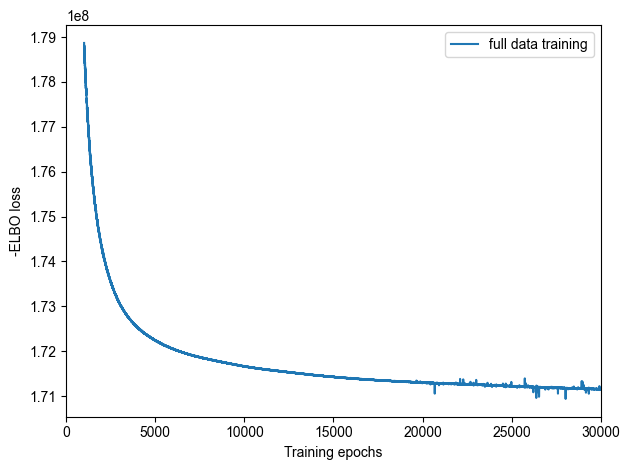

In [57]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [58]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_st = mod.export_posterior(
    adata_st, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name5}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name5}/sp.h5ad"
adata_st.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:52<00:00, 18.95it/s]


'../file/Mouse_Embryo_Brain_3D/cell2location_result/cell2location_map_st5/sp.h5ad'

## 3.6

In [9]:
adata_st=adata_3d[shuffled_numbers[69875:83850]]#adata_3d[(adata_3d.obs['z']>404)&(adata_3d.obs['z']<535)]
sc.pp.filter_genes(adata_st, min_cells=10)
adata_st

AnnData object with n_obs × n_vars = 13975 × 19678
    obs: 'sample', 'reg', 'Spot_col', 'Spot_row', 'z'
    var: 'Symbol', 'type', 'mt', 'n_cells'
    obsm: 'spatial', 'spatial_3d_align'
    layers: 'spliced', 'unspliced'

In [10]:
inf_aver=pd.read_csv(f'{ref_run_name}/inf_aver.csv',index_col=0)
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_st.var_names, inf_aver.index)
adata_st = adata_st[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_st, batch_key="sample")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [11]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_st, cell_state_df=inf_aver,
    N_cells_per_location=20,
    detection_alpha=20, #count与HE细胞密集程度高：200 esle 20
    detection_mean_per_sample=True #多个空间样本 True
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.3.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  93   │
│         n_cells          │ 13975 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 14157 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │    5-4     │          0          │
│                     │    5-5     │          1          │
│                     │    5-7     │          2          │
│                     │    5-8     │          3          │
│                     │    5-9     │          4          │
│                     │    7-1     │          5          │
│                     │    7-2     │          6          │
│                     │    7-3     │          7          │
│                     │    7-4     │          8          │
│                     │    7-5     │          9          │
│                     │    7-8     │         10          │
│                     │    8-3     │         11          │
│                     │    8-4     │         12          │
│                     │    8-5     │         13          │
│                     │    8-6     │         14          │
│                     │    8-7     │         15          │
│                     │    8-8     │         16          │
│                     │    8-9     │         17          │
│                     │    9-1     │         18          │
│                     │    9-2     │         19          │
│                     │    9-3     │         20          │
│                     │    9-8     │         21          │
│                     │    9-9     │         22          │
│                     │    10-2    │         23          │
│                     │    10-3    │         24          │
│                     │    10-4    │         25          │
│                     │    10-5    │         26          │
│                     │    10-6    │         27          │
│                     │    10-7    │         28          │
│                     │    10-8    │         29          │
│                     │    10-9    │         30          │
│                     │    11-3    │         31          │
│                     │    11-5    │         32          │
│                     │    11-6    │         33          │
│                     │    11-7    │         34          │
│                     │    11-9    │         35          │
│                     │    13-1    │         36          │
│                     │    13-2    │         37          │
│                     │    13-3    │         38          │
│                     │    13-4    │         39          │
│                     │    13-6    │         40          │
│                     │    13-7    │         41          │
│                     │    13-8    │         42          │
│                     │    14-1    │         43          │
│                     │    14-3    │         44          │
│                     │    14-4    │         45          │
│                     │    14-5    │         46          │
│                     │    14-6    │         47          │
│                     │    14-7    │         48          │
│                     │    14-8    │         49          │
│                     │    14-9    │         50          │
│                     │    16-1    │         51          │
│                     │    16-2    │         52          │
│                     │    16-3    │         53          │
│                     │    16-4    │         54          │
│                     │    16-5    │         55          │
│                     │    16-6    │         56          │
│                     │    16-7    │         57          │
│                     │    16-8    │         58          │
│                     │    16-9    │         59          │
│                     │    17-2    │         60          │
│                     │    17-3    │         61          │
│                     │    17-4    │         62          │
│                     │    17-5    │         63

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [12]:
mod.train(max_epochs=30000,
          batch_size=None,
          use_gpu=True
         )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 30000/30000: 100%|██████████| 30000/30000 [2:03:25<00:00,  4.42it/s, v_num=1, elbo_train=1.7e+8]   

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|██████████| 30000/30000 [2:03:25<00:00,  4.05it/s, v_num=1, elbo_train=1.7e+8]


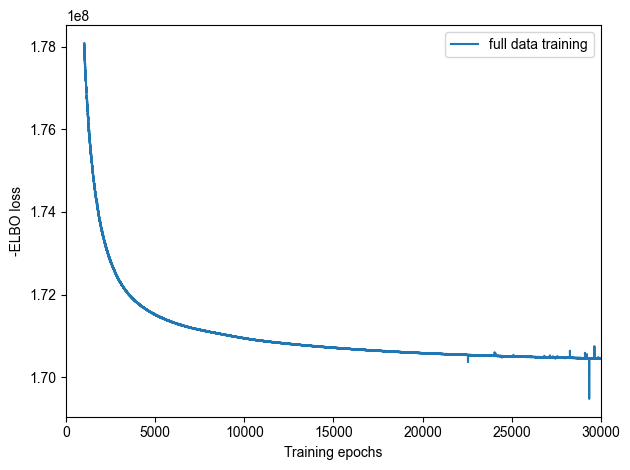

In [13]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [14]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_st = mod.export_posterior(
    adata_st, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name6}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name6}/sp.h5ad"
adata_st.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:47<00:00, 21.16it/s]


'../file/Mouse_Embryo_Brain_3D/cell2location_result/cell2location_map_st6/sp.h5ad'

## 3.7

In [15]:
adata_st=adata_3d[shuffled_numbers[83850:]]#adata_3d[adata_3d.obs['z']>534]
sc.pp.filter_genes(adata_st, min_cells=10)
adata_st

AnnData object with n_obs × n_vars = 13980 × 19740
    obs: 'sample', 'reg', 'Spot_col', 'Spot_row', 'z'
    var: 'Symbol', 'type', 'mt', 'n_cells'
    obsm: 'spatial', 'spatial_3d_align'
    layers: 'spliced', 'unspliced'

In [16]:
inf_aver=pd.read_csv(f'{ref_run_name}/inf_aver.csv',index_col=0)
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_st.var_names, inf_aver.index)
adata_st = adata_st[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_st, batch_key="sample")

In [17]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_st, cell_state_df=inf_aver,
    N_cells_per_location=20,
    detection_alpha=20, #count与HE细胞密集程度高：200 esle 20
    detection_mean_per_sample=True #多个空间样本 True
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.3.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  93   │
│         n_cells          │ 13980 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 14178 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │    5-4     │          0          │
│                     │    5-5     │          1          │
│                     │    5-7     │          2          │
│                     │    5-8     │          3          │
│                     │    5-9     │          4          │
│                     │    7-1     │          5          │
│                     │    7-2     │          6          │
│                     │    7-3     │          7          │
│                     │    7-4     │          8          │
│                     │    7-5     │          9          │
│                     │    7-8     │         10          │
│                     │    8-3     │         11          │
│                     │    8-4     │         12          │
│                     │    8-5     │         13          │
│                     │    8-6     │         14          │
│                     │    8-7     │         15          │
│                     │    8-8     │         16          │
│                     │    8-9     │         17          │
│                     │    9-1     │         18          │
│                     │    9-2     │         19          │
│                     │    9-3     │         20          │
│                     │    9-8     │         21          │
│                     │    9-9     │         22          │
│                     │    10-2    │         23          │
│                     │    10-3    │         24          │
│                     │    10-4    │         25          │
│                     │    10-5    │         26          │
│                     │    10-6    │         27          │
│                     │    10-7    │         28          │
│                     │    10-8    │         29          │
│                     │    10-9    │         30          │
│                     │    11-3    │         31          │
│                     │    11-5    │         32          │
│                     │    11-6    │         33          │
│                     │    11-7    │         34          │
│                     │    11-9    │         35          │
│                     │    13-1    │         36          │
│                     │    13-2    │         37          │
│                     │    13-3    │         38          │
│                     │    13-4    │         39          │
│                     │    13-6    │         40          │
│                     │    13-7    │         41          │
│                     │    13-8    │         42          │
│                     │    14-1    │         43          │
│                     │    14-3    │         44          │
│                     │    14-4    │         45          │
│                     │    14-5    │         46          │
│                     │    14-6    │         47          │
│                     │    14-7    │         48          │
│                     │    14-8    │         49          │
│                     │    14-9    │         50          │
│                     │    16-1    │         51          │
│                     │    16-2    │         52          │
│                     │    16-3    │         53          │
│                     │    16-4    │         54          │
│                     │    16-5    │         55          │
│                     │    16-6    │         56          │
│                     │    16-7    │         57          │
│                     │    16-8    │         58          │
│                     │    16-9    │         59          │
│                     │    17-2    │         60          │
│                     │    17-3    │         61          │
│                     │    17-4    │         62          │
│                     │    17-5    │         63

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [18]:
mod.train(max_epochs=30000,
          batch_size=None,
          use_gpu=True
         )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 30000/30000: 100%|██████████| 30000/30000 [2:01:24<00:00,  4.25it/s, v_num=1, elbo_train=1.72e+8]  

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|██████████| 30000/30000 [2:01:24<00:00,  4.12it/s, v_num=1, elbo_train=1.72e+8]


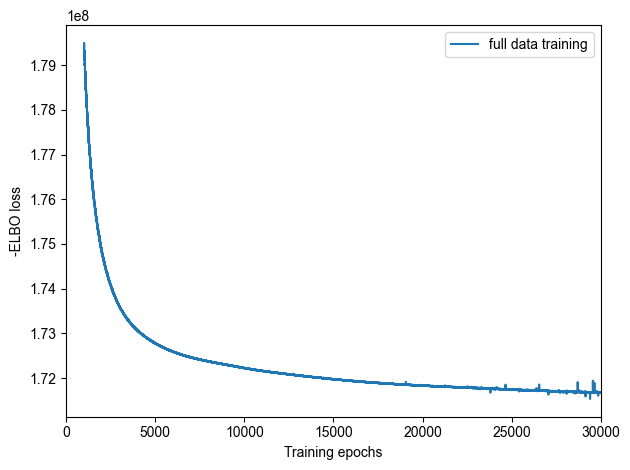

In [19]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [20]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_st = mod.export_posterior(
    adata_st, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name7}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name7}/sp.h5ad"
adata_st.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:45<00:00, 21.89it/s]


'../file/Mouse_Embryo_Brain_3D/cell2location_result/cell2location_map_st7/sp.h5ad'